# Wavelength calibration
The wavelength solution, in general, is provided in the FITS header of each frame. 
For *ultra*-stable instruments, this solution will not change over the course of an observing night. 
However, there are situations where the different spectra might be slightly misaligned and the wavelength solution might be inaccurate.

In [1]:
#------ manually fix import for now
import sys
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import Template
from redcross.align import Align, WaveSolution


c = 2.99e5
%load_ext autoreload
%autoreload 2

In [2]:
night = '1'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)

dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/datacube_input_posB.npy


Working with 3 lines
Working with 3 lines


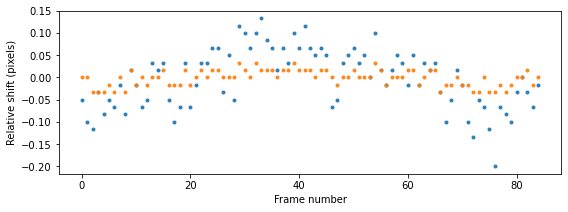

In [156]:
order = 48
dco = dc.order(order).remove_continuum()
al = Align(dco)
fig, ax = plt.subplots(1,figsize=(9,3))
al.apply_shifts(ax=plt.gca())
dco = al.dco

al = Align(dco)
al.apply_shifts(ax=plt.gca())

## Telluric template

In [157]:
from skycalc_ipy import SkyCalc
from scipy.interpolate import splrep, splev
# wmax i nm
instrument = 'giano'
wmax = {'harpsn':700, 'giano':2500}
dict_sky = {'airmass':1.2, 'wgrid_mode':'fixed_spectral_resolution', 'wres':200e3,
           'vacair':'vac', 'ra':dc.RA_DEG, 'dec':dc.DEC_DEG, 'mjd':np.median(dc.MJD), 'wmax':wmax[instrument]}
skycalc = SkyCalc()
for key, item in dict_sky.items():
    skycalc[key]=item

run_skycalc = False
if run_skycalc:
    print('hii')
    tbl = skycalc.get_sky_spectrum()
    tbl['lam'] *= 1e4
    print('hiiiiii')
    np.save('data/skycalc_tellurics_{:}.npy'.format(instrument), tbl)
else:
    tbl = np.load('data/skycalc_tellurics_{:}.npy'.format(instrument), allow_pickle=True)
# temp = Template(wlt=tbl['lam'], flux=tbl['trans'])

temp = Template()
# resample template to match the same number of pixels (constant step size)
temp.wlt = np.linspace(dco.wlt.min(), dco.wlt.max(), dco.nPix)
cs = splrep(tbl['lam'], tbl['trans'])
temp.flux = splev(temp.wlt, cs)


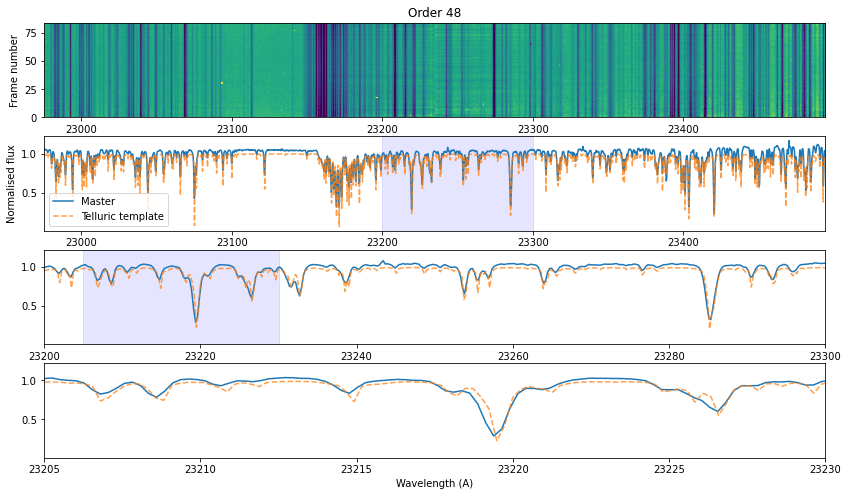

In [158]:
%matplotlib inline
fig, ax = plt.subplots(4,figsize=(14,8))
plt.subplots_adjust(hspace=0.2)


def plot_master(dco, ax=None, **kwargs):
    
    master = Template(wlt=np.median(dco.wlt, axis=0), flux=np.median(dco.flux, axis=0))
    master.flux /= np.median(master.flux)
    master.pix = np.arange(0, master.wlt.size)
    ax.plot(master.wlt, master.flux, **kwargs)
    return master


dco = dc.order(order).remove_continuum()
dco.imshow(ax=ax[0])

for i in range(1,4):
    master = plot_master(dco, ax[i], label='Master')

    temp.plot(ax=ax[i], alpha=0.75, ls='--', label='Telluric template')
ax[1].set(xlim=(master.wlt.min(), master.wlt.max()))

xranges = [(23200, 23300), (23205, 23230)]
for i in range(2,4):
    ax[i-1].axvspan(xranges[i-2][0], xranges[i-2][1], alpha=0.1, color='b')
    ax[i].set(xlim=xranges[i-2])

ax[1].legend()
ax[0].set(ylabel='Frame number', title='Order {:}'.format(order))
ax[1].set(ylabel='Normalised flux')
ax[len(ax)-1].set(xlabel='Wavelength (A)')

plt.show()
# fig.savefig('plots/spectra_telluric_data_order{:}.png'.format(order), dpi=200, facecolor='white', bbox_inches='tight')

## Calibrate wavelength solution with telluric template

In [159]:
# Get telluric lines from the telluric template (get indeces and wavelength values of the centroids)
order = 48
dco = dc.order(order).remove_continuum()

ws = WaveSolution(dco, frame=10)
ws.spec.flux /= np.median(ws.spec.flux)
ws.edge = 6
ws.scale_pix = 1/20.


# mask = (temp.wlt>dco.wlt.min())&(temp.wlt<dco.wlt.max())
ws.temp = Template(wlt=temp.wlt, flux=temp.flux)

ws.get_peaks(threshold=0.1)
tel_peaks = ws.peaks
ws.temp.peaks_wave = ws.temp.wlt[tel_peaks] 
print('Peaks found in telluric template {:}'.format(tel_peaks.size))

Peaks found in telluric template 28


Working with 25 lines


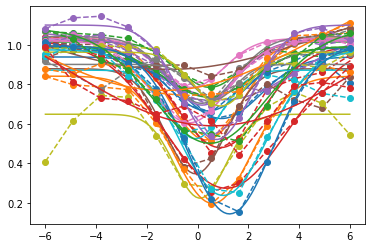

In [160]:
# get the corresponding (closest) master wavelengths from the telluric peaks
ws.get_peaks_wave()

# fit gaussians to find the master peak centroids (in pixels)
ax = plt.gca()
ws.gaussian_centroids(ws.spec.peaks_ind, 0.5, ax)
print('Working with {:} lines'.format(ws.temp.peaks_wave.size))
# define first wavelength solution (peak, wavelength)
polyfit = np.polyfit(ws.centroids, ws.temp.peaks_wave, 4)
poly = np.poly1d(polyfit)(ws.spec.pix)

# spline interpolate to refine the wave solution
n = ws.centroids.size
# fig, ax = plt.subplots(n, figsize=(10, n*2))
ws.centroids_ref = np.zeros_like(ws.centroids) # refined centroids
for i in range(len(ws.centroids)):
    ws.centroids_ref[i] = ws.spline_super_sampling(ws.centroids[i], ws.spec.flux, ax=None)

# refined solution
polyfit = np.polyfit(ws.centroids_ref, ws.temp.peaks_wave, 4)
poly_ref = np.poly1d(polyfit)(ws.spec.pix)

# np.save('data/wave_sol/night{:}_pos{:}_order{:}.npy'.format(night, position, order), poly_ref)

In [161]:
# # spline interpolate to refine the wave solution
# n = ws.centroids.size
# fig, ax = plt.subplots(n, figsize=(10, n*2))
# ws.centroids_ref = np.zeros_like(ws.centroids) # refined centroids
# for i in range(len(ws.centroids)):
#     ws.centroids_ref[i] = ws.spline_super_sampling(ws.centroids[i], ws.master.flux, ax=ax[i])
    
# plt.show()

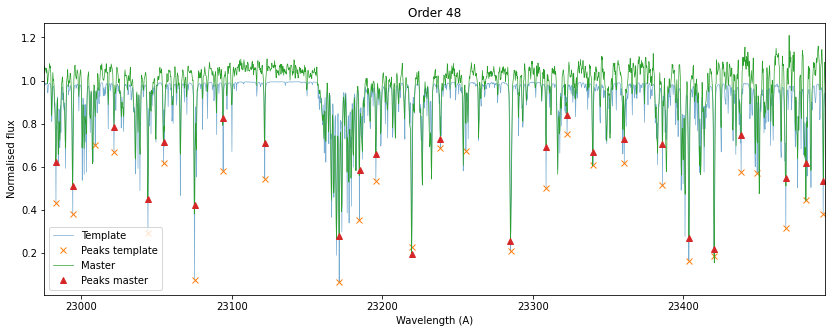

In [162]:
fig, ax = plt.subplots(1, figsize=(14,5))
ax.plot(ws.temp.wlt, ws.temp.flux, '-', lw=0.7, alpha=0.6, label='Template')
ax.plot(ws.temp.wlt[ws.peaks], ws.temp.flux[ws.peaks], 'x', label='Peaks template')

ax.plot(ws.spec.wlt, ws.spec.flux, lw=0.7, label='Master')
ax.plot(ws.spec.peaks_wave, ws.spec.flux[ws.spec.peaks_ind], '^', label='Peaks master')
ax.legend()

ax.set(xlabel='Wavelength (A)', ylabel='Normalised flux', title='Order {:}'.format(order))
ax.set_xlim(ws.spec.wlt.min(), ws.spec.wlt.max())
plt.show()

# outname = 'plots/giano_master_template_peaks_order{:}.png'.format(order)
# fig.savefig(outname, dpi=200, bbox_inches='tight', facecolor='white')

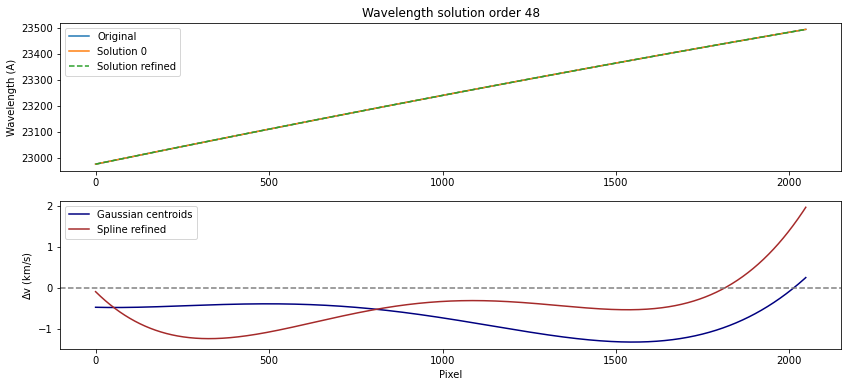

In [165]:
fig, ax = plt.subplots(2,1, figsize=(14,6))
ax[0].plot(ws.spec.wlt, label='Original')


# ax[0].plot(ws.centroids, ws.temp.peaks_wave,'.', label='Cal 0')
ax[0].plot(poly, label='Solution 0', ls='-')
ax[0].plot(poly_ref, label='Solution refined', ls='--')

res_gcentroids = c*(ws.spec.wlt - poly)/np.median(ws.spec.wlt)
res_spline = c*(ws.spec.wlt - poly_ref)/np.median(ws.spec.wlt)
ax[1].plot(res_gcentroids, c='navy', label='Gaussian centroids')
ax[1].plot(res_spline, c='brown', label='Spline refined')
ax[1].axhline(0.0, ls='--', c='gray')

[ax[k].legend() for k in range(2)]
ax[0].set(ylabel='Wavelength (A)', title='Wavelength solution order {:}'.format(order))
ax[1].set(xlabel='Pixel', ylabel='$\Delta$v (km/s)')
plt.show()
# outname = 'plots/giano_wavesol_order{:}.png'.format(order)
# fig.savefig(outname, dpi=200, bbox_inches='tight', facecolor='white')

In [ ]:
night = '1'
position = 'A'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)

dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(position))

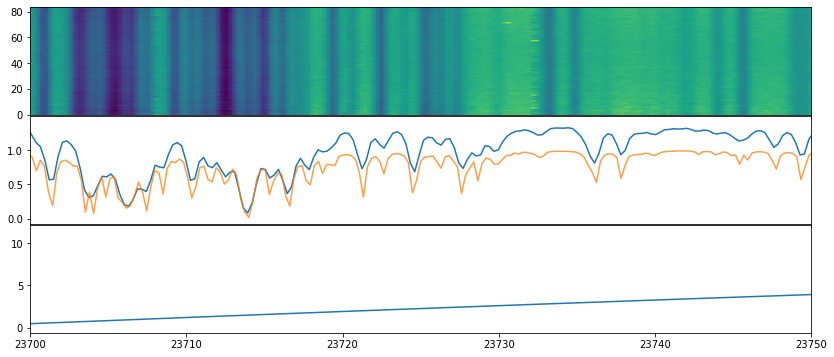

In [142]:
order = 49
dco = dc.order(order).remove_continuum()
dco.flux /= np.mean(dco.flux)
wave = np.median(dco.wlt, axis=0)

fig, ax = plt.subplots(3,1,figsize=(14,6), sharex=True)
plt.subplots_adjust(hspace=0.01)
dco.imshow(ax=ax[0])
dco.plot(ax=ax[1])

# mask = (temp.wlt>dco.wlt.min())&(temp.wlt<dco.wlt.max())

# ax[1].plot(temp.wlt[mask], temp.flux[mask], alpha=0.75)
# ax[1].plot(wave - )
ax[1].plot(temp.wlt, temp.flux, alpha=0.75)
ax[2].plot(wave, wave - temp.wlt)

ax[0].set_xlim(23700, 23750)

plt.show()


In [128]:
temp.wlt[mask].shape

(4471,)

Working with 18 lines
Working with 24 lines
Working with 16 lines
Working with 16 lines
Working with 18 lines
Working with 23 lines
Working with 20 lines
Working with 19 lines
Working with 18 lines
Working with 19 lines
Working with 20 lines


KeyboardInterrupt: 

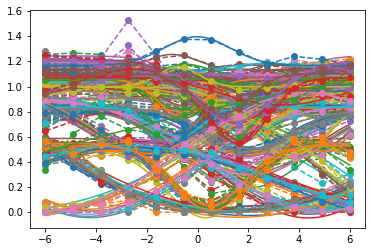

In [107]:
# Get telluric lines from the telluric template (get indeces and wavelength values of the centroids)
order = 49
dco = dc.order(order).remove_continuum()

# al = Align(dco)
# al.apply_shifts()
# dco = al.dco
# al.apply_shifts()
# dco = al.dco


wavesol = np.zeros((dco.nObs, dco.nPix))

for f in range(dco.nObs):
    ws = WaveSolution(dco, frame=f)
    ws.spec.flux /= np.median(ws.spec.flux)



    mask = (temp.wlt>dco.wlt.min())&(temp.wlt<dco.wlt.max())
    ws.temp = Template(wlt=temp.wlt[mask], flux=temp.flux[mask])

    ws.get_peaks(threshold=0.01)
    tel_peaks = ws.peaks
    ws.temp.peaks_wave = ws.temp.wlt[tel_peaks] 
#     print('Peaks found in telluric template {:}'.format(tel_peaks.size))


    # get the corresponding (closest) master wavelengths from the telluric peaks
    ws.get_peaks_wave()

    # fit gaussians to find the master peak centroids (in pixels)
    ax = plt.gca()
    ws.gaussian_centroids(ws.spec.peaks_ind, 0.1, ax)
    print('Working with {:} lines'.format(ws.temp.peaks_wave.size))
    # define first wavelength solution (peak, wavelength)
    polyfit = np.polyfit(ws.centroids, ws.temp.peaks_wave, 4)
    poly = np.poly1d(polyfit)(ws.spec.pix)

    # spline interpolate to refine the wave solution
    n = ws.centroids.size
    # fig, ax = plt.subplots(n, figsize=(10, n*2))
    ws.centroids_ref = np.zeros_like(ws.centroids) # refined centroids
    for i in range(len(ws.centroids)):
        ws.centroids_ref[i] = ws.spline_super_sampling(ws.centroids[i], ws.spec.flux, ax=None)

    # refined solution
    polyfit = np.polyfit(ws.centroids_ref, ws.temp.peaks_wave, 4)
    poly_ref = np.poly1d(polyfit)(ws.spec.pix)
    wavesol[f,] = poly_ref

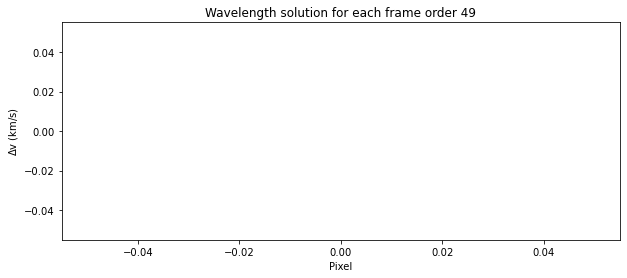

In [143]:
wavesol_med = np.median(wavesol, axis=0)
c = 2.99e5

fig, ax = plt.subplots(1, figsize=(10,4))

# res = wavesol - wavesol_med
res = wavesol - temp.wlt
deltav = c*res/np.median(wavesol)
[ax.plot(deltav[f,], alpha=0.6) for f in range(deltav.shape[0])]

# ax.legend()

ax.set(xlabel='Pixel', ylabel='$\Delta$v (km/s)', title='Wavelength solution for each frame order {:}'.format(order))
plt.show()

In [96]:
save_dir = data_dir+'wavesols/wavesol_order{:}.txt'.format(order)
np.savetxt(save_dir, wavesol)

In [98]:
np.mean(np.std(deltav, axis=0))

0.3945975133104815

In [12]:
res = wavesol-dco.wlt
np.mean(np.std(res, axis=0))

print('1 pixel is 0.25 A')
print('Order 48 shows residuals of 0.28 A or ~ 0.1 pixel ~ 0.3 km/s')
print('TO-DO: improve routine to select the best hyperparameters automatically')
print('RIght now it is very sensitive to `threshold` & `tolerance`')

1 pixel is 0.25 A
Order 48 shows residuals of 0.28 A or ~ 0.1 pixel ~ 0.3 km/s
TO-DO: improve routine to select the best hyperparameters automatically
RIght now it is very sensitive to `threshold` & `tolerance`


In [13]:
np.mean(np.diff(dco.wlt))

0.25359660905666415